In [1]:
from fastai.data.all import *
from fastai.vision.all import *
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.data.las import *
from enveco.model.inception3dv3 import *
from enveco.model.ensemble import *
from enveco.interpretation import *
from enveco.metrics import *
from fastai.callback.progress import ShowGraphCallback

# Read data

Read field plot data used for training and validation

In [2]:
basedir = Path('../../../andras/ml/AV_leafon/')
#basedir = Path('../../enveco_data/enveco/')

train_df = pd.read_csv(basedir/'AV.leaf.on.train.csv')
valid_df = pd.read_csv(basedir/'AV.leaf.on.val.csv')
train_df['is_val'] = False
valid_df['is_val'] = True

df = pd.concat((train_df, valid_df))

df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v.ma,v.ku,v.lp,myear,filename.1,a.date.1,a.window.1,filename.2,a.date.2,a.window.2,v.lp.proc,is_val
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,False
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,False
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,False
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,False
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,False


Create `VoxelDataLoaders` from dataframe.

* `bin_voxels` controls whether to set all voxels to be either 0 or 1
* `mask_plot` controls whether to mask all locations outside 9m radius from center
* `bottom_voxels` controls whether to fill all voxels under any detected voxel

`DihedralItem` provides on-the-fly rotations as augmentations.

In [3]:
target_col = 'v'
dls = VoxelDataLoaders.from_df(df, path=basedir, folder='AV_las/', 
                               bin_voxels=False, 
                               bottom_voxels=False, 
                               mask_plot=True,
                               y_block=RegressionBlock(), 
                               label_col=target_col, fn_col='sampleplotid', bs=16,
                               batch_tfms=[DihedralItem], 
                               valid_col='is_val')

In [5]:
dls.one_batch()

(VoxelImage size=16x1x105x40x40,
 tensor([ 54.8800, 137.7900,   2.7000,  17.9700, 139.5900, 265.9100, 165.0600,
         126.0600,  65.9300, 120.2400,  81.9300,  64.0400, 152.1900, 131.5200,
         215.5400, 251.9600], device='cuda:0'))

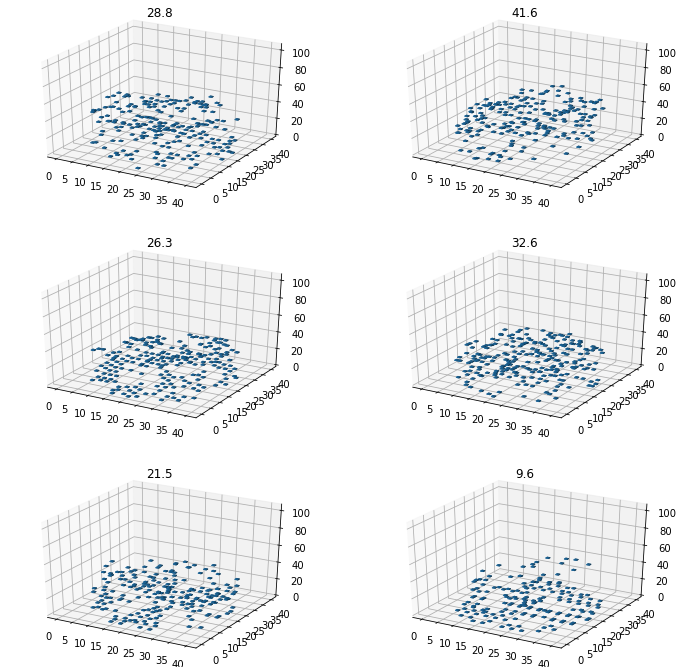

In [87]:
dls.show_batch()

# Learner

Set metrics to use

In [6]:
metrics = [rmse, rrmse, bias, bias_pct, mae, R2Score()]

Create learner

In [7]:
inc_learner = inception_learner(dls, path='.', metrics=metrics,  y_range=(0,dls.train.items[target_col].max() * 1.1))
#inc_learner.to_fp16()

Search for a good learning rate

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=7.585775847473997e-07)

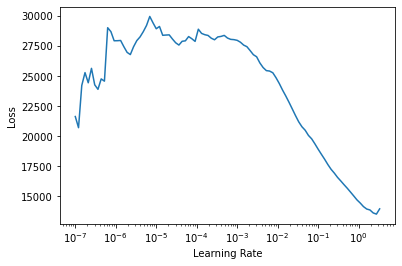

In [8]:
inc_learner.lr_find()

Fit with one cycle scheduling.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,18038.214844,20512.558594,143.222061,94.994614,-126.633507,-83.991951,126.633492,-1.253929,00:20
1,8142.422852,8111.685059,90.064896,59.737164,-69.323692,-45.980186,70.472038,0.108685,00:17
2,3799.095215,649701.250000,806.040466,534.620850,533.622986,353.935059,533.622986,-70.389460,00:17
3,2337.960205,10377.250000,101.868790,67.566315,68.466690,45.411766,69.715851,-0.140257,00:17
4,2049.225586,5991.774902,77.406555,51.341290,-61.598907,-40.856583,62.375893,0.341621,00:17
5,1909.472046,4766.702148,69.041306,45.792889,-47.617241,-31.582993,49.844177,0.476233,00:17
6,1868.840698,1603.734741,40.046654,26.561665,-14.722277,-9.764815,28.661924,0.823781,00:17
7,1967.037354,6959.664062,83.424599,55.332870,55.699177,36.943481,57.607494,0.235269,00:17
8,1862.650269,2015.325928,44.892380,29.775679,1.687086,1.118990,28.195120,0.778555,00:18
9,1631.524292,1289.454224,35.908970,23.817270,-2.559371,-1.697549,24.207954,0.858314,00:17


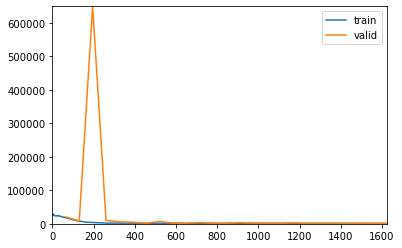

In [9]:
inc_learner.fit_one_cycle(25, lr_max=1e-2, cbs=ShowGraphCallback())

# See results

In [10]:
reg_interp = RegressionInterpretation.from_learner(inc_learner, ds_idx=1)

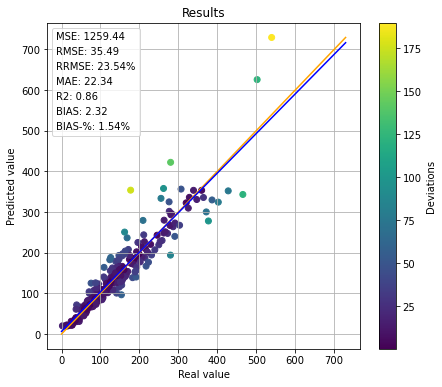

In [11]:
reg_interp.plot_results()
plt.show()

In [3]:
test_df = pd.read_csv(basedir/'AV.leaf.on.test.csv')

In [4]:
test_dl = inc_learner.dls.test_dl(test_df, with_labels=True)

NameError: name 'inc_learner' is not defined

In [14]:
test_interp = RegressionInterpretation.from_learner(inc_learner, dl=test_dl)

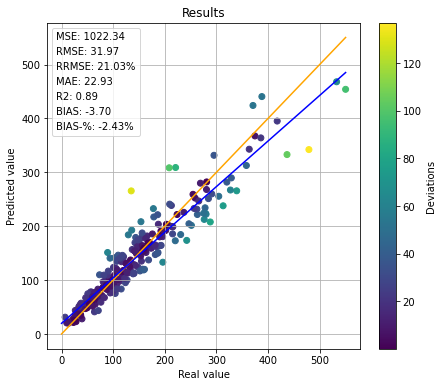

In [15]:
test_interp.plot_results()
plt.show()

In [16]:
inc_learner.export(f'models/{target_col}_voxels.pkl')

# Test that loading works

In [5]:
target_col = 'v'

In [6]:
inc_learner = load_learner(f'models/{target_col}_voxels.pkl', cpu=False)
test_dl = inc_learner.dls.test_dl(test_df, with_labels=True)

In [7]:
test_interp = RegressionInterpretation.from_learner(inc_learner, dl=test_dl)

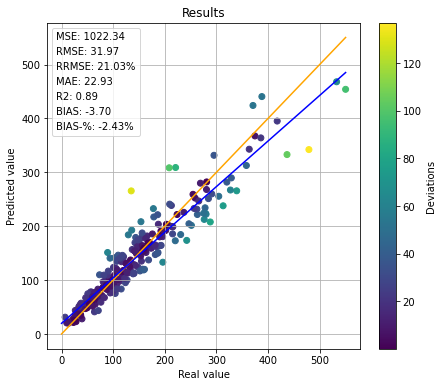

In [8]:
test_interp.plot_results()
plt.show()

# Species-wise volumes from previously predicted proportions

Proportions of different tree species are predicted based on aerial images.

In [9]:
preds, targs = inc_learner.get_preds(dl=test_dl)

In [10]:
vol_df = test_df[['sampleplotid', 'v', 'v.ma', 'v.ku', 'v.lp']].copy()
vol_df['pred_v'] = np.round(preds[:,0].numpy(), 2)

In [11]:
vol_df

,sampleplotid,v,v.ma,v.ku,v.lp,pred_v
0,901025,220.31,0.00,141.55,78.77,172.979996
1,901037,295.26,0.00,202.92,92.34,331.519989
2,901058,206.61,189.46,16.39,0.76,201.970001
3,902066,374.58,163.94,193.44,17.21,367.429993
4,902074,479.10,163.34,294.22,21.54,342.160004
...,...,...,...,...,...,...
220,923113,59.72,57.06,0.00,2.66,51.709999
221,923116,186.18,133.72,0.00,52.45,221.300003
222,923117,185.98,181.17,0.24,4.57,149.690002
223,923127,167.37,156.83,10.54,0.00,168.399994


In [12]:
rel_preds = pd.read_csv('../../results/rel_proportions.csv')

In [13]:
rel_preds

,sampleplotid,rel_v_ma,pred_v_ma,rel_v_ku,pred_v_ku,rel_v_lp,pred_v_lp
0,901025,0.000,0.001,0.643,0.017,0.358,0.982
1,901037,0.000,0.000,0.687,0.500,0.313,0.500
2,901058,0.917,0.685,0.079,0.163,0.004,0.152
3,902066,0.438,0.578,0.516,0.312,0.046,0.110
4,902074,0.341,0.542,0.614,0.315,0.045,0.142
...,...,...,...,...,...,...,...
220,923113,0.955,0.887,0.000,0.047,0.045,0.066
221,923116,0.718,0.899,0.000,0.052,0.282,0.050
222,923117,0.974,0.959,0.001,0.015,0.025,0.026
223,923127,0.937,0.971,0.063,0.009,0.000,0.020


In [14]:
rel_preds = rel_preds[['sampleplotid', 'pred_v_ma', 'pred_v_ku', 'pred_v_lp']]

In [15]:
combined = vol_df.merge(rel_preds, on='sampleplotid')
combined.head()

,sampleplotid,v,v.ma,v.ku,v.lp,pred_v,pred_v_ma,pred_v_ku,pred_v_lp
0,901025,220.31,0.00,141.55,78.77,172.979996,0.001,0.017,0.982
1,901037,295.26,0.00,202.92,92.34,331.519989,0.000,0.500,0.500
2,901058,206.61,189.46,16.39,0.76,201.970001,0.685,0.163,0.152
3,902066,374.58,163.94,193.44,17.21,367.429993,0.578,0.312,0.110
4,902074,479.10,163.34,294.22,21.54,342.160004,0.542,0.315,0.142


In [16]:
combined['pred_v_ma_tot'] = combined.v * combined.pred_v_ma
combined['pred_v_ku_tot'] = combined.v * combined.pred_v_ku
combined['pred_v_lp_tot'] = combined.v * combined.pred_v_lp

In [17]:
import matplotlib.patches as mpl_patches

def plot_regression(y, preds, title, log_y:bool=False, **kwargs) -> plt.Axes:
    "Similar plotting utility than RegressionInterpretation for scikit-learn models"
    #if len(preds.shape) != 2: preds = preds[:,None]
    cols = title
    y = y.values
    preds = preds#.values
    if log_y: 
        preds = np.expm1(preds)
        y = np.expm1(y)
    axs = get_grid(1, figsize=((6+1), (6))) # if we have multitarget
    for a in axs:

        im = a.scatter(y, preds, c=np.abs(y-preds))
        a.set_xlabel('Real value')
        a.set_ylabel('Predicted value')
        a.set_title(cols)
        a.grid()
        x = np.linspace(0, max(preds.max(),y.max()))
        a.plot(x, x, color='orange')
        m, b = np.polyfit(y, preds, 1)
        a.plot(x, m*x+b, color='blue')
        cbar = plt.colorbar(im, ax=a)
        cbar.ax.set_ylabel('Deviations', rotation=90)
        res_mae = mae(Tensor(y), Tensor(preds))
        res_mse = mse(Tensor(y), Tensor(preds))
        res_rmse = rmse(Tensor(y), Tensor(preds))
        res_rrmse = res_rmse / y.mean() * 100
        res_rmsle = msle(tensor(y), Tensor(preds))**.5
        res_nrmse = res_rmse / (y.max() - y.min()) * 100
        r2 = R2Score()(Tensor(y), Tensor(preds))
        res_bias = bias(Tensor(y), Tensor(preds))
        res_pct_bias = bias_pct(Tensor(y), Tensor(preds))
        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                   lw=0, alpha=0)] * 8
        labels = [f'MSE: {res_mse:.2f}', f'RMSE: {res_rmse:.2f}', f'RRMSE: {res_rrmse:.2f}%',
                  f'RMSLE: {res_rmsle:.2f}', f'NRSME: {res_nrmse:.2f}%',
                  f'MAE: {res_mae:.2f}', f'R2: {r2:.2f}', 
                  f'BIAS: {res_bias:.2f}', f'BIAS-%: {res_pct_bias:.2f}%']
        a.legend(handles, labels, loc='best', fancybox=True, handlelength=0, handletextpad=0)
    return axs

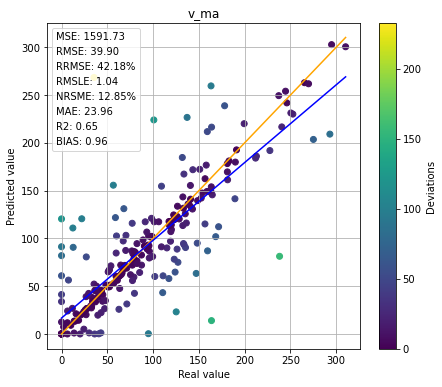

In [18]:
plot_regression(combined['v.ma'], combined.pred_v_ma_tot, 'v_ma')

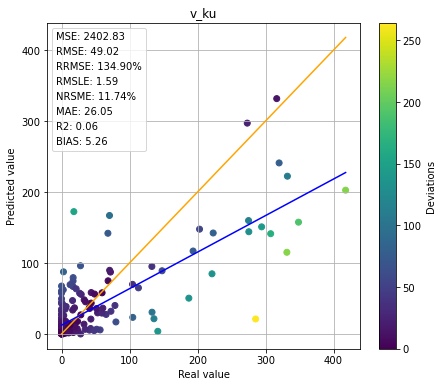

In [19]:
plot_regression(combined['v.ku'], combined.pred_v_ku_tot, 'v_ku')

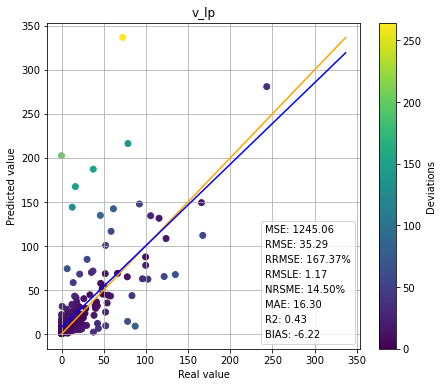

In [20]:
plot_regression(combined['v.lp'], combined.pred_v_lp_tot, 'v_lp')